In [16]:
import pandas as pd 
import sqlite3
import scipy.stats as sps
import matplotlib.pyplot as plt
from dataclasses import dataclass
import numpy as np

In [3]:
match_data = pd.read_hdf('data.h5','match_data')
hero_names_map = pd.read_hdf('data.h5','names_map')
gen_stats = pd.read_hdf('data.h5','gen_stats')


In [35]:
with sqlite3.Connection('../data_source/dota2base.db') as c:
    matrix_data = pd.read_sql('''select
                                win_team,
                                stats_type,
                                lose_team,
                                sum(value) as cumulative_stats
                                from matrix_table
                                group by 1,
                                        2,
                                        3
                                ''',con=c)

In [37]:
matrix_data.pivot('win_team',['stats_type','lose_team']).droplevel(0,axis=1)

stats_type count                                         ... sum              \
lose_team    1   2   3   4    5   6    7    8   9   10   ... 119 120 121 123   
win_team                                                 ...                   
1            NaN NaN NaN NaN  NaN NaN  NaN  NaN NaN NaN  ... NaN NaN NaN NaN   
2            NaN NaN NaN NaN  NaN NaN  NaN  NaN NaN NaN  ... NaN NaN NaN NaN   
3            NaN NaN NaN NaN  NaN NaN  NaN  NaN NaN NaN  ... NaN NaN NaN NaN   
4            NaN NaN NaN NaN  NaN NaN  NaN  NaN NaN NaN  ... NaN NaN NaN NaN   
5            NaN NaN NaN NaN  NaN NaN  1.0  NaN NaN NaN  ... NaN NaN NaN NaN   
...          ...  ..  ..  ..  ...  ..  ...  ...  ..  ..  ...  ..  ..  ..  ..   
128          NaN NaN NaN NaN  1.0 NaN  NaN  1.0 NaN NaN  ... NaN NaN NaN NaN   
129          NaN NaN NaN NaN  NaN NaN  NaN  NaN NaN NaN  ... NaN NaN NaN NaN   
135          NaN NaN NaN NaN  1.0 NaN  NaN  NaN NaN NaN  ... NaN NaN NaN NaN   
136          NaN NaN NaN NaN  NaN NaN  NaN  NaN NaN NaN  ... NaN NaN NaN NaN   
137          NaN NaN NaN NaN  NaN NaN  NaN  NaN NaN NaN  ... NaN NaN NaN NaN   

stats_type                           
lose_team  126 128  129 135 136 137  
win_team                             
1          NaN NaN  NaN NaN NaN NaN  
2          NaN NaN  NaN NaN NaN NaN  
3          NaN NaN  NaN NaN NaN NaN  
4          NaN NaN  NaN NaN NaN NaN  
5          NaN NaN  NaN NaN NaN NaN  
...         ..  ..  ...  ..  ..  ..  
128        NaN NaN  0.0 NaN NaN NaN  
129        NaN NaN  NaN NaN NaN NaN  
135        NaN NaN  NaN NaN NaN NaN  
136        NaN NaN  NaN NaN NaN NaN  
137        NaN NaN  NaN NaN NaN NaN  

[110 rows x 216 columns]

In [4]:
hero_matrix = match_data\
    .groupby(['match_id','team_number','radiant_win'])\
        .agg({'hero_id':set})\
            .unstack(1)\
                .droplevel(0,axis=1)\
                    .explode([0,1])\
                        .reset_index(1)\
                            .pivot_table('radiant_win',0,1,aggfunc =['count','sum'])

In [14]:
hero_matrix.melt(ignore_index=False).reset_index()
['index','type','columns','value']

,0,NaN,1,value
0,1,count,1,NaN
1,2,count,1,2170.0
2,3,count,1,524.0
3,4,count,1,1039.0
4,5,count,1,1330.0
...,...,...,...,...
30253,128,sum,137,70.0
30254,129,sum,137,93.0
30255,135,sum,137,38.0
30256,136,sum,137,51.0


In [6]:
hero_matrix = hero_matrix.rename(hero_names_map).rename(columns= hero_names_map)

In [12]:
@dataclass
class Hero:
    hero_matrix:pd.DataFrame

    def __post_init__(self):
        if not isinstance(self.hero_matrix,pd.DataFrame):
            raise ValueError('нужен dataframe')
        self.hero_matrix = self.hero_matrix.sum()
        self.value_space = np.array([np.linspace(.5,.99)]*self.hero_matrix['sum'].shape[0]).T
        self.defeats = self.hero_matrix['count'] - self.hero_matrix['sum']
        self.wins = self.hero_matrix['sum']
        
    def get_scores(self):
        hero_distr = sps.beta(self.wins+1,self.defeats+1)

        log_like = np.log1p(hero_distr.sf(self.value_space)).sum(axis=0) / hero_distr.std()


        return pd.Series(log_like,self.wins.index)
        
    def plot_top(self,n=10):
        scores = self.get_scores().sort_values()

        data = pd.concat([scores.iloc[:10],
                            scores.iloc[-10:],]
                        ).rename('win log like').to_frame().apply(lambda x: (x-x.mean()) / (x.max()-x.min()))
        return data.plot.bar(title=self.hero_matrix.name)

In [13]:
pugna = Hero(hero_matrix.loc[['pugna']])
antimage = Hero(hero_matrix.loc[['antimage']])

In [14]:
team_a = Hero(hero_matrix.loc[['pugna','antimage',]])

In [15]:
team_a.get_scores().round(3).sort_values(ascending=False)

1
tinker         415.852
batrider       298.107
invoker        248.834
shredder       243.998
rubick         239.102
                ...   
ursa             0.035
jakiro           0.005
centaur          0.001
axe              0.000
drow_ranger      0.000
Length: 123, dtype: float64

<AxesSubplot:xlabel='1'>

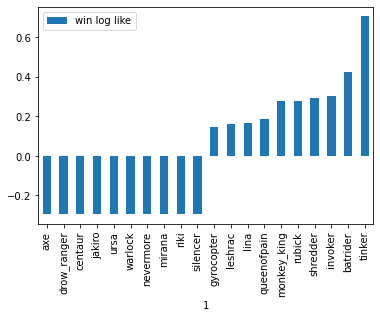

In [17]:
team_a.plot_top()